# Lesson 04: Makemore - Activations, Gradients and Batchnorm

## 01: Setup
Tidy up of working code in preparation for diving into the internals of MLPS. Investigationg the forward pass activation, backward pass gradients and some gotchas.

In [1]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt, random
g = torch.Generator().manual_seed(2147483647)

In [2]:
words = open("../names.txt").read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))) + ['.'])
itos = {idx: ch for idx, ch in enumerate(chars)}
stoi = {v:k for k, v in itos.items()}


In [4]:
def build_dataset(words, block_size=3):
    # build the full dataset
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def split_dataset(X,Y):
    random.seed(42); 
    random.shuffle(words) # randomly shuffle words
    
    n1 = int(0.8 * X.shape[0])
    n2 = int(0.9 * X.shape[0])
    Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
    print(Xtr.shape, Ytr.shape)
    print(Xdev.shape, Ydev.shape)
    print(Xts.shape, Yts.shape)
    return Xtr, Ytr, Xdev, Ydev, Xts, Yts


@torch.no_grad() # this decorator disables gradient tracking - avoid bookkeeping for torch which is more efficient
def split_loss(split):
    # calculates the loss for datasets
    x,y = {"train": (Xtr, Ytr),"val": (Xdev, Ydev),"test": (Xts, Yts)}[split]
        
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    h = torch.tanh(embcat @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

In [5]:
# setup hyperparameters 
block_size = 3 # the number of input characters
vocab_size = 27 # distinct range of input characters
n_embed = 10 # the dimensionality of the character embedding space
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# build test, dev and train datasets
Xtr, Ytr, Xdev, Ydev, Xts, Yts = split_dataset(*build_dataset(words, block_size))

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22815, 3]) torch.Size([22815])
torch.Size([22815, 3]) torch.Size([22815])


## 01.1 Basic Training

In [6]:
# initalise the nn 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden,vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [14]:
# standard training run for baseline loss calculation
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 28.1530


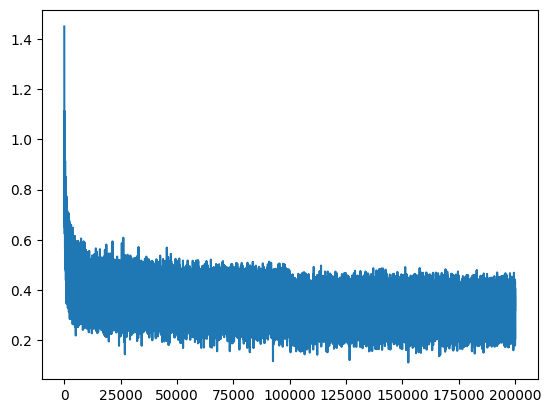

In [60]:
plt.plot(lossi);

In [71]:
# loss with random initialisation:
split_loss('train') # 2.067
split_loss('val') # 2.374
split_loss('test')


# train 2.119797468185425
# val 2.1673247814178467
# test 2.1634275913238525

train 2.0362894535064697
val 2.104016065597534
test 2.099142074584961


## 02 model sampling

Setup sampling from the model

In [70]:
for _ in range(20):
    context = [0] * block_size
    word = []
    while True:
        
        emb = C[context]
        embcat = emb.view(1,-1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if itos[ix] == '.':
            break
        word.append(itos[ix])
        context = context[1:] + [ix]
    print(''.join(word))

nylaylin
kotusana
ramaria
ston
pinrynn
lariyaan
jozlyia
harmettoca
icilyn
kenzelsamree
dael
jailouwa
yason
corie
andella
nyonedlynn
yasii
affynda
ah
levyn


## 03 Investigate and fixing the initial loss
First step has very high loss (27.8), we'd like much lower. It's high as the weights are just random. We'd want initial loss to be around a uniform distribution 1/27.0, so loss is 3.2958. If the model is confidently wrong the loss is much higher. We want to start the training with a lower loss, and initials the model's weights, we can do this by multiplying the weights and bias by a small or zero to make the loss closer to 0 and more uniform.

In [160]:
# we want the loss to be uniform so the loss should initially be: 
-torch.tensor(1/27.0).log()
# but we get a very messed up, and the model is very confidently wrong

tensor(3.2958)

In [162]:
# 4d example of the issue:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [179]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss # can be very high loss

(tensor([-2.0687, -2.2561,  9.4957, 22.7108]),
 tensor([1.7314e-11, 1.4356e-11, 1.8229e-06, 1.0000e+00]),
 tensor(13.2151))

In [183]:
# run the code above and break afrer the first iteration and look at the first item in the minibatch. Look at the logits
# where the loss is very high ~28
logits[0]

tensor([ 20.4446, -13.4149, -25.8656,   6.3718,  11.2841,  28.9982, -25.0925,
        -15.1387,  23.3197,   2.4465,  10.4902, -12.7129,  -1.1194,  -4.8172,
         -0.3411, -28.8215, -21.4922, -16.8877, -20.7713,   7.5535,  -5.8498,
         -0.0803,  -4.9603,  -3.6459,  -0.7197,  -0.7587, -18.2604],
       grad_fn=<SelectBackward0>)

In [62]:
# initalise the nn with better initialised loss: 
# not zero for W2, as need entropy, for symmetry breaking
# this stops neurons behaving in the same way, so each neuron learns different aspects of the data. if they were all 0 
# all neurons learn the  same feature.
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01  # not zero!
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [63]:
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break # break after the first iteration so that we can check the internals and remove break to run to get loss


      0/ 200000: 3.3281
  10000/ 200000: 1.8562
  20000/ 200000: 2.1495
  30000/ 200000: 1.7990
  40000/ 200000: 2.2084
  50000/ 200000: 2.0626
  60000/ 200000: 2.3251
  70000/ 200000: 2.1669
  80000/ 200000: 2.3564
  90000/ 200000: 2.2258
 100000/ 200000: 2.1637
 110000/ 200000: 2.4788
 120000/ 200000: 2.1509
 130000/ 200000: 2.5400
 140000/ 200000: 2.1478
 150000/ 200000: 1.5578
 160000/ 200000: 2.1594
 170000/ 200000: 2.0527
 180000/ 200000: 2.1420
 190000/ 200000: 2.1626


train 2.070784568786621
val 2.129239320755005
test 2.134359359741211


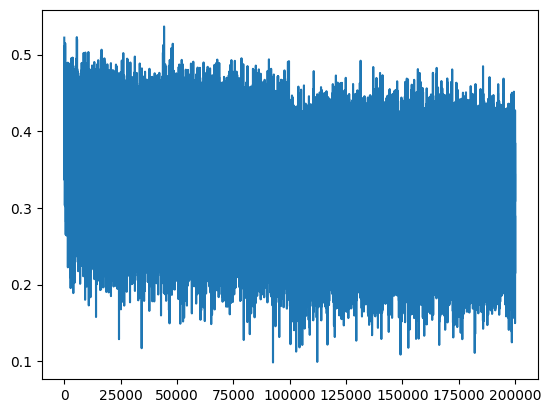

In [64]:
# don't waste iterations (1000's) just squashing down the weights, and spend more cycles optimising the nn.
# the starting loss is 3.3195. and loss is better:
split_loss('train') # 2.070 compared to 2.136 before
split_loss('val') # 2.147 compared to 2.184 before
split_loss('test')
plt.plot(lossi);

## 04 Fixing the saturated tanh

If the inputs to the tanh activiation function are too high or too low the output is close to +/- 1. Tanh is a squashing function, it squashes inputs into the -1 to + 1 range. At values close to 1 or -1 the gradient = 0 and the neuron can not be trained, Any input into this activiation from other neurons is reduced to 0 gradient. 

Instead we want the inputs into tanh to be more distributed around mean of 0.


In [190]:
# looking at h:
h.shape, h

(torch.Size([32, 200]),
 tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000,  0.9999,  0.9999],
         [-1.0000,  0.9719, -0.0251,  ...,  0.9101,  0.9999,  0.9999],
         [-0.3260, -0.9999, -0.9993,  ...,  1.0000, -0.6485, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000,  0.9999,  0.9999],
         [-1.0000,  0.9808, -0.1404,  ..., -0.9967, -1.0000,  0.9941],
         [-0.9699,  0.6070,  1.0000,  ..., -1.0000,  0.9995,  1.0000]],
        grad_fn=<TanhBackward0>))

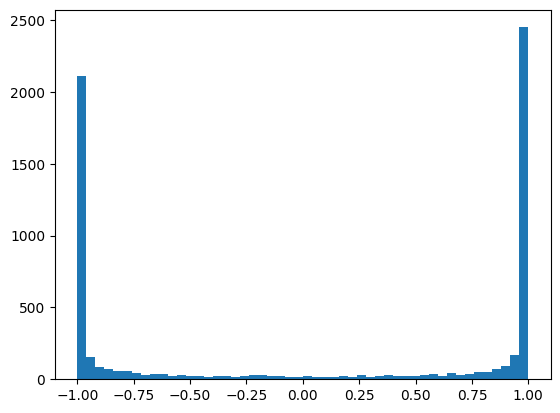

In [30]:
# look at histogram of the distribution in 50 buckets. This shows high humber of values at -1 and 1:
plt.hist(h.view(-1).tolist(), 50);

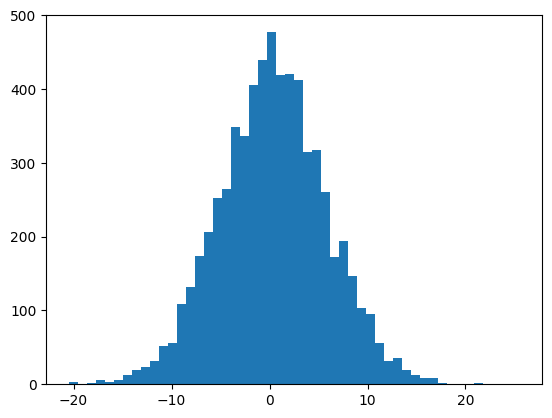

In [31]:
# similarly for hpreact, input into the hidden layer tanh:
plt.hist(hpreact.view(-1).tolist(), 50);

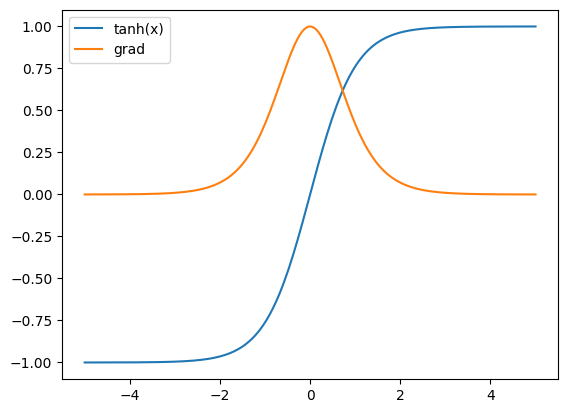

In [18]:
# the hidden preactivations, hpreact, when +/- 2 produce nearly saturated tanh values (see h), they are nearly 1 or -1. 
# At this point the gradients go to 0. For tanh the derivative is 1-tanh(x)**2.

# For our hidden layer with 200 tanh. Any gradient passed through the tanh function could end up with ~0 gradient when tanh(x) = +/-1, so 
# killing any contribution from the neuron. Anything before this function would have no impact after it.
# The gradients flowing through tanh can only be decreased, as inputs are squashed between -1 and 1, x = -5, y=-1. 
# Best case is tanh(0) = 1, grad = 1, full prior grad values flow through

x = torch.linspace(-5,5,steps =200)
grad = lambda x : 1-torch.tanh(x)**2

plt.plot(x, torch.tanh(x), label='tanh(x)')
plt.plot(x, grad(x), label='grad')
plt.legend();

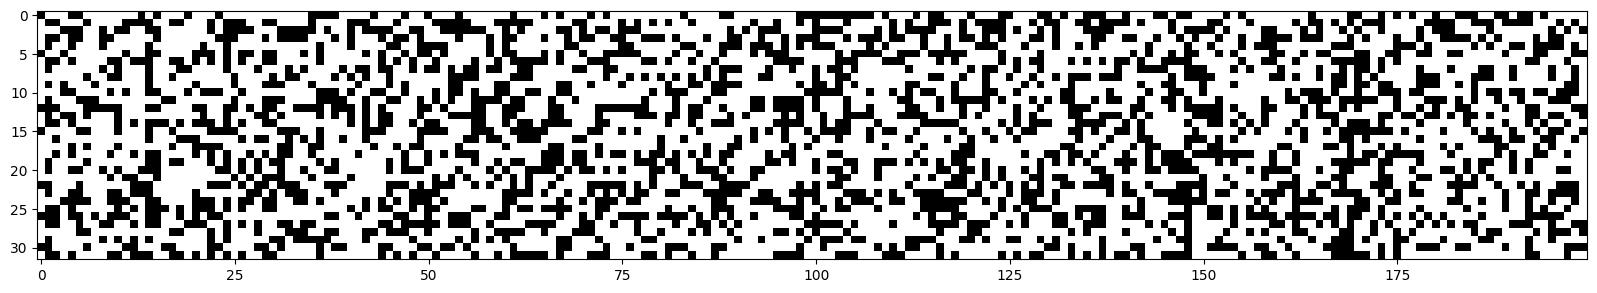

In [32]:
# check how often the gradient of the hidden layer is in the flat area:

h.shape # (32,200) shows for each minibatch training example if the h is in the dead zone, on the flat areas of tanh()

# where it's white it's saturated, if the whole column is white the neuron is dead. There are no neurons which are all white, so all neurons are learning 
# for some examples. If the whole column is white activation is either 1 or -1 so grad is 0, the neuron won't learn and dead.
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest');

In [26]:
h[15,50:60]

tensor([ 0.1480,  0.5633,  0.9994,  1.0000,  0.9998, -0.9987,  0.3891, -0.9976,
         1.0000,  0.9998], grad_fn=<SliceBackward0>)

#### Other Activations 

Other activations (non-linear) functions behave different: sigmid, tanh, reLU, LeakyReLU, Maxout, ELU

- sigmoid - can have the same behaviour as tanh
- ReLU - gradient can be knocked out, if all inputs negative, then the neuron will never learn as it's grad = 0 and it's dead, this can happen at initialisation
 or during optimisation where the neuron get's knocked out , e.g activation is -ive, sometimes due to too high a learning rate. 
-  leaky reLU - doesn't suffere as much as no flat parts

Instead, we want to optimise it so less white, neurons, and too many satuated neurons and we want the neurons to update more frequently.
We want hpreact to be closer to zero. 


In [66]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2 # squash the weights
b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # not zero
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01  # not zero!
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [67]:
# rerun the first batch
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    # break # break after the first iteration so that we can check the internals and remove break to run to get loss

      0/ 200000: 3.3129
  10000/ 200000: 1.7365
  20000/ 200000: 2.0989
  30000/ 200000: 1.8554
  40000/ 200000: 2.2316
  50000/ 200000: 2.1342
  60000/ 200000: 2.3009
  70000/ 200000: 2.1032
  80000/ 200000: 2.3019
  90000/ 200000: 2.2144
 100000/ 200000: 2.1413
 110000/ 200000: 2.3880
 120000/ 200000: 2.1501
 130000/ 200000: 2.5244
 140000/ 200000: 1.8961
 150000/ 200000: 1.5457
 160000/ 200000: 1.9835
 170000/ 200000: 1.9218
 180000/ 200000: 1.7968
 190000/ 200000: 2.2548


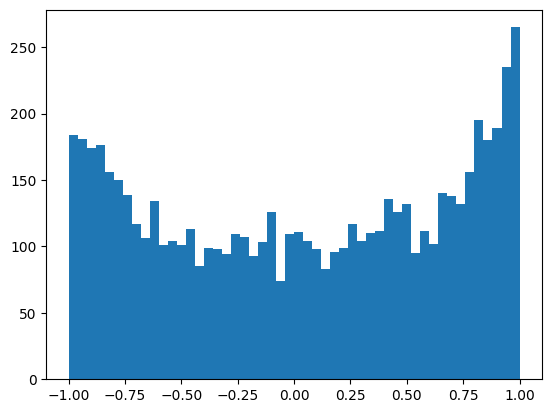

In [35]:
# much better activations none abs(1):
plt.hist(h.view(-1).tolist(), 50);

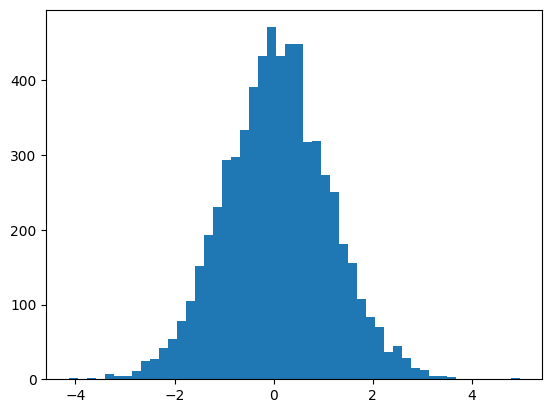

In [37]:
# similarly for hpreact, input into the hidden layer tanh:
plt.hist(hpreact.view(-1).tolist(), 50);

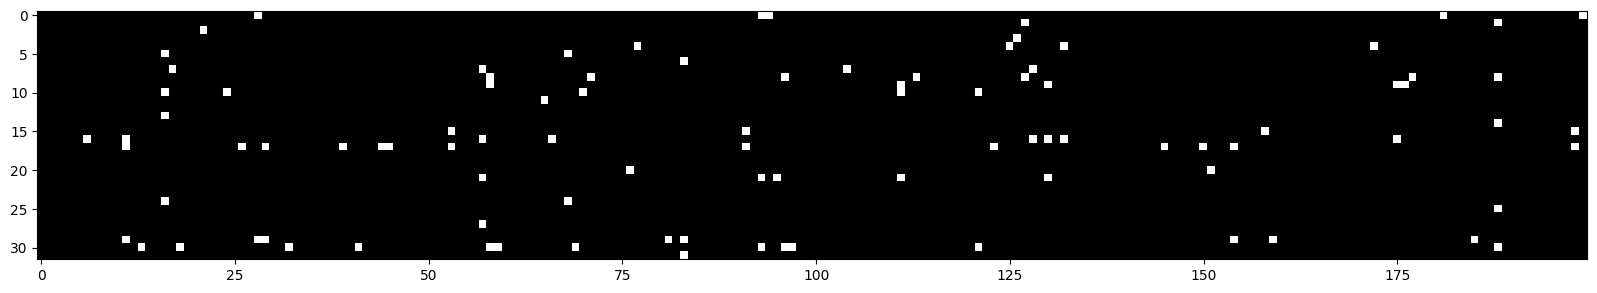

In [38]:
# no examples from the mini-batch where neuron tanh is saturated:

plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest');

## 05 Calculating the init scale with Kaiming init

So far we used magic numbers to scale the initial weights. Instead we'll calculate this with an algorithm

tensor(-0.0078) tensor(1.0013)
tensor(0.0372) tensor(27.3404)


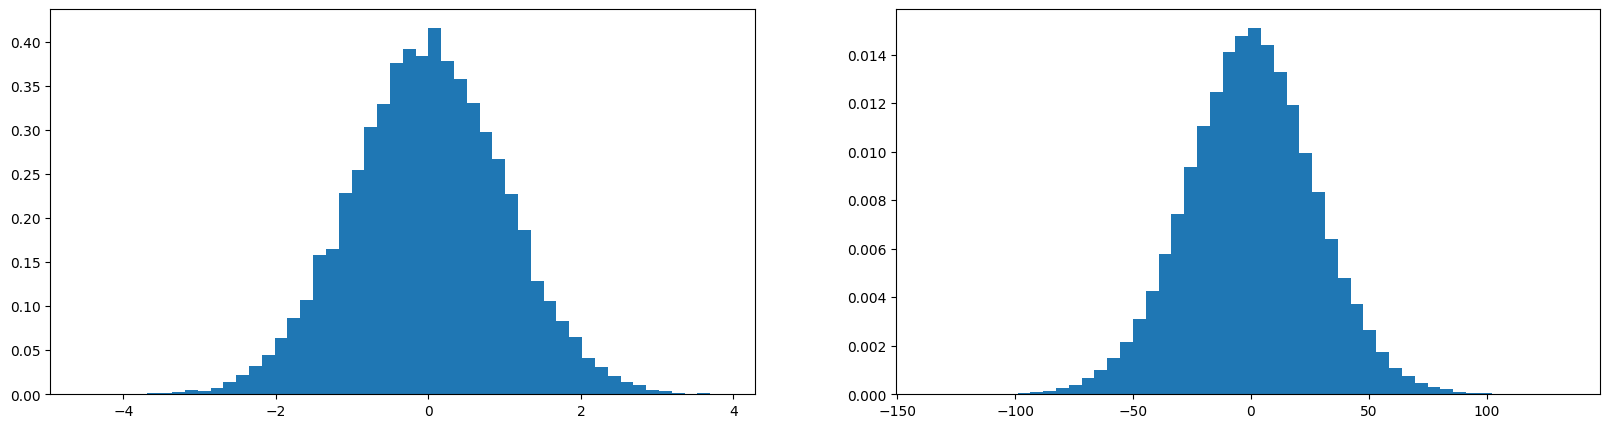

In [94]:
# consider x inputs and weights, w with gaussian (normal) distributions. These are standard normal distributions which have mean = 0
# and std dev = 1. Notice that y plot, expands, showing higher standard deviations, values take on more and more extreme values
x = torch.randn(1000,30)
w = torch.randn(30,200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121) # creating 1 row, 2 cols, index for multiple plots in figure
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0034) tensor(1.0005)
tensor(0.0040) tensor(0.9801)


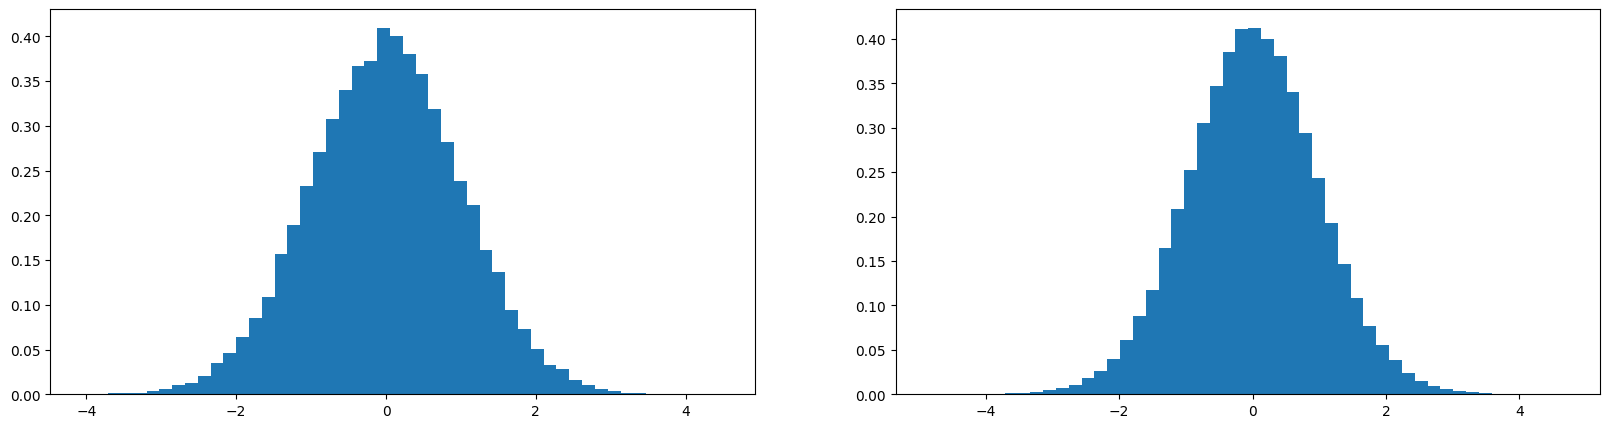

In [93]:
# to fix this, how do I preserve the std dev of 1. You divide the fan in (inputs params) by the square root:

x = torch.randn(1000,30)
w = torch.randn(30,200) / 30 **0.5 # divide the fan in the square root
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121) # creating 1 row, 2 cols, index for multiple plots in figure
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [84]:
# how the gaussian is scaled down, the distribution is scaled down by scaling it:
torch.randn(10000).std(), (torch.randn(100000) * 0.2).std()

(tensor(0.9937), tensor(0.1998))

In [89]:
# 5/3 is the gain when using the tanh activiation function, so for our model, we can adjust the 'kaiming init' for our network.
# The gain is different for each activation function.
(5/3) / (30 **0.5) # 0.3

0.3042903097250923

In [36]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),              generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size) ** 0.5) # << not a magic number any more kaiming init
b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # not zero
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01  # not zero!
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [37]:
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    # break # break after the first iteration so that we can check the internals and remove break to run to get loss

      0/ 200000: 3.3324
  10000/ 200000: 1.7292
  20000/ 200000: 2.3331
  30000/ 200000: 2.3266
  40000/ 200000: 2.1299
  50000/ 200000: 2.1190
  60000/ 200000: 1.5408
  70000/ 200000: 2.1104
  80000/ 200000: 2.2821
  90000/ 200000: 1.9034
 100000/ 200000: 2.5578
 110000/ 200000: 1.9454
 120000/ 200000: 1.8072
 130000/ 200000: 2.0132
 140000/ 200000: 1.8676
 150000/ 200000: 1.9323
 160000/ 200000: 2.0712
 170000/ 200000: 2.0603
 180000/ 200000: 2.4685
 190000/ 200000: 1.9960


train 1.9888941049575806
val 2.3367061614990234
test 2.3725171089172363


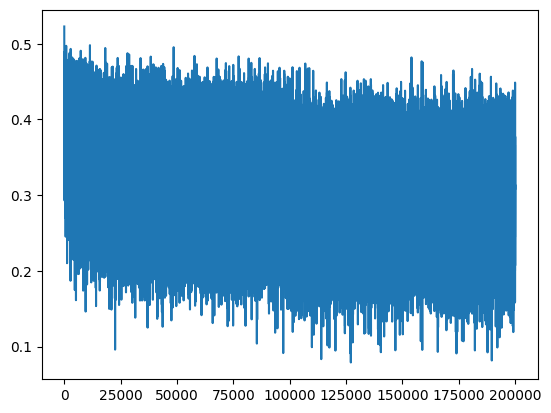

In [38]:
# loss
split_loss('train')
split_loss('val')
split_loss('test')
plt.plot(lossi);

## 06 Batch Normalisation

Initialisation isn't as important now, due to some modern innovations. It's not important now to get the optimisation exactly right as. We use residual connections, normalisation layers and better optimisers - not just stochastic gradient descent, like Adam. 

Here we are investigating batch normalisation. Hidden states like hpreact, need not be low or too high. Instead they need to be roughly gaussian (unit gaussian), so why not normalise them to be gaussian. They are perfectly differentiable. This is the insight from batch normalisation, you can normalise the hidden layer weights. 

Unit gaussian is the same as a normal distribution with mean=0 and sd = 1. We can use a weight and a bias to move the hpreacts by scaling and shifting the weights.

In [22]:
# run the last part of the kaiming init above to get a hpreact. We want to normalise hpreact using it's mean and std.

hp_mean = hpreact.mean(0, keepdim=True) # 0 dimension, first dim and down the list
hpreact.shape, hp_mean.shape

(torch.Size([32, 200]), torch.Size([1, 200]))

In [15]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [19]:
# what does normalisation of unit gaussian mean: 
x = torch.tensor([4,6,8,2,10,12]).float()
x_mean = x.mean()
x_std = x.std()
x_norm = (x - x_mean)/ x_std # unit gaussian using the Z-score formula

x, x_norm

(tensor([ 4.,  6.,  8.,  2., 10., 12.]),
 tensor([-0.8018, -0.2673,  0.2673, -1.3363,  0.8018,  1.3363]))

In [20]:
# unit gaussian, mean = 0 std = 1
x_norm.mean(), x_norm.std()

(tensor(0.), tensor(1.))

To implement batch normalisation there are two parts: 
- Part 1: is to normalise the activations in the hidden layer using the batch's (32 training examples) mean and standard deviation and,
- Part 2: Scale and shift - where we take the normalised inputs and scaling them by a gain and shifted by a bias. So each neuron is scaled and shifted. These are additional parameters which we tune via backpropagition, the same as other parameters. `bngain` and `bnbias`

In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size) ** 0.5) # kaiming init - 5/3 for tanh activation func
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# batch normalisation - initial config
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

12297


In [28]:
# same optimisation as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # normalise hidden pre activation weights
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function 
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.3146
  10000/ 200000: 1.7510
  20000/ 200000: 2.0701
  30000/ 200000: 1.8895
  40000/ 200000: 2.2146
  50000/ 200000: 2.3078
  60000/ 200000: 2.3731
  70000/ 200000: 2.2683
  80000/ 200000: 2.2226
  90000/ 200000: 2.2088
 100000/ 200000: 2.2854
 110000/ 200000: 2.3586
 120000/ 200000: 2.2060
 130000/ 200000: 2.4909
 140000/ 200000: 2.0337
 150000/ 200000: 1.6717
 160000/ 200000: 2.1091
 170000/ 200000: 1.8940
 180000/ 200000: 1.9386
 190000/ 200000: 2.3823


In [29]:
@torch.no_grad() # this decorator disables gradient tracking - avoid bookeeping for torch which is more efficient
def split_loss_bn_meanstd_not_calc(split):
    # calculates the loss for datasets
    x,y = {"train": (Xtr, Ytr),"val": (Xdev, Ydev),"test": (Xts, Yts)}[split]
        
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

train 2.0688300132751465
val 2.1077871322631836
test 2.1062490940093994


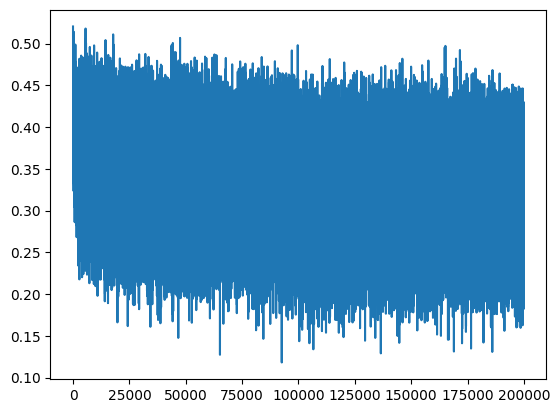

In [30]:
# we don't expect the loss to improve, as we only have a very simple single layer. But if we had many layers, it's much harder to tune and scale the weight matrixes to make them unit gaussian.
split_loss_bn_meanstd_not_calc('train')
split_loss_bn_meanstd_not_calc('val')
split_loss_bn_meanstd_not_calc('test')
plt.plot(lossi);

# train 2.0688300132751465
# val 2.1077871322631836
# test 2.1062490940093994

When we have many hidden layers we sprinkle batch normalisation layers throughout the network between each linear layer.

The cost of this stability is that the batch examples are coupled together as we are normalising them in the hidden pre-activitation layer. this means that the input into `h` will change based on what other examples are in the batch. This causes a jitter, but this is actually good, as a side-effect! It's a regulariser, it's padding out and introducing entropy and data argumentation, and so avoid the network from overfitting. So this 2nd order effect is good! 

But no one likes this and have created other normalising techniques which do not couple training examples in a batch.

#### Sample from the model with batch normalisation
the network expects a mean and std from a batch to provide an output. How do we calculate this for a single example? The proposal is to have a step after training to set the batch mean and std over the whole set and use that for the the sampling calculation and to calculate loss. We can also use the full mean and std for calculating the loss.


In [33]:
# calculate the batch norm at the end of training using the full training set
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() # this decorator disables gradient tracking - avoid bookeeping for torch which is more efficient
def split_loss_bn_calc_meanstd(split):
    # calculates the loss for datasets
    x,y = {"train": (Xtr, Ytr),"val": (Xdev, Ydev),"test": (Xts, Yts)}[split]
        
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item()) 

In [35]:
# loss with mean and std calculated across the whole training set. These match pretty much with the mean and std calculated from the last batch.
split_loss_bn_calc_meanstd('train')
split_loss_bn_calc_meanstd('val')
split_loss_bn_calc_meanstd('test')
train 2.0688300132751465
val 2.107856273651123
test 2.1061854362487793

train 2.0688300132751465
val 2.107856273651123
test 2.1061854362487793


In [47]:
# although we don't want to do a seperate calculation after the training run, so instead we want to calculate it during training as follows: 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size) ** 0.5) # kaiming init - 5/3 for tanh activation func
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# batch normalisation - initial config
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # never derive gradients, updated on the side of training
bnstd_running = torch.ones((1, n_hidden)) # never derive gradients, updated on the side of training

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

# keep a running mean and std during the training run
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activations
    bnmeani = hpreact.mean(0, keepdim=True) # calculate mean for each training step, initially roughly 0
    bnstdi = hpreact.std(0, keepdim=True) # calcuated std for each training step, initially roughly 1 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # normalise hidden pre activation weights
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # no grad descent, and running mean calculation. we can use these two for loss and sampling after training
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())  

12297
      0/ 200000: 3.3146
  10000/ 200000: 1.7510
  20000/ 200000: 2.0701
  30000/ 200000: 1.8895
  40000/ 200000: 2.2146
  50000/ 200000: 2.3078
  60000/ 200000: 2.3731
  70000/ 200000: 2.2683
  80000/ 200000: 2.2226
  90000/ 200000: 2.2088
 100000/ 200000: 2.2854
 110000/ 200000: 2.3586
 120000/ 200000: 2.2060
 130000/ 200000: 2.4909
 140000/ 200000: 2.0337
 150000/ 200000: 1.6717
 160000/ 200000: 2.1091
 170000/ 200000: 1.8940
 180000/ 200000: 1.9386
 190000/ 200000: 2.3823


In [51]:
# compare the running and Xtr calculated mean and std, showing they are very similar:
bnmean.mean(), bnmean_running.mean(), bnmean.std(), bnmean_running.std()

(tensor(0.1546), tensor(0.1547), tensor(1.1400), tensor(1.1405))

In [52]:
bnstd.mean(), bnstd_running.mean(), bnstd.std(), bnstd_running.std()

(tensor(2.1333), tensor(2.1160), tensor(0.2389), tensor(0.2386))

In [53]:
@torch.no_grad() # this decorator disables gradient tracking - avoid bookeeping for torch which is more efficient
def split_loss_bn_running_meanstd(split):
    # calculates the loss for datasets
    x,y = {"train": (Xtr, Ytr),"val": (Xdev, Ydev),"test": (Xts, Yts)}[split]
        
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item()) 

In [54]:
split_loss_bn_running_meanstd('train')
split_loss_bn_running_meanstd('val')
split_loss_bn_running_meanstd('test')
# train 2.0688300132751465
# val 2.107856273651123
# test 2.1061854362487793

train 2.068878173828125
val 2.1080706119537354
test 2.1064822673797607


Other points on batch normalisation. 
- A very small epsolon constant is added to the denominator to avoid div by 0 if the std deviation is 0, for numerical stability. This doesn't chance the result very much.

`hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1**-5) + bnbias`

- Bias in the hpreact is not useful, as we're calcuating the mean and then removing it on the step after, and so don't impact the rest of the calcuation. 
Any weight layers which have a bias and with batch normalisation after it aren't required and you can remove it. Batch norm has it's own bias and the bias in the hidden layer would be subtracted out anyway (by the mean). If you look at the activations of b they stay constant, don't get a gradient. Bias is removed below.


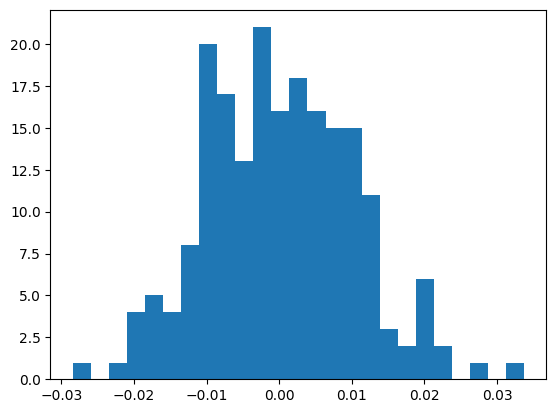

In [56]:
plt.hist(b1.view(-1).tolist(), 25);

In [60]:
b1.mean(), b1.std()

(tensor(0.0002, grad_fn=<MeanBackward0>),
 tensor(0.0102, grad_fn=<StdBackward0>))

In [78]:
# example of different bias added to a tensor and normalisation, showing that it doesn't matter what the bias is as it is removed:
x= torch.tensor([1,2,3,4,5]).float()
b1 = torch.tensor([10])
b2 = torch.tensor([20])
y = x + b1
z = x + b2
y_norm = y - y.mean()
z_norm = z - z.mean()
y_norm, z_norm

(tensor([-2., -1.,  0.,  1.,  2.]), tensor([-2., -1.,  0.,  1.,  2.]))

In [5]:
# although we don't want to do a seperate calculation after the training run, so instead we want to calculate it during training as follows: 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size) ** 0.5) # kaiming init - 5/3 for tanh activation func
W2 = torch.randn((n_hidden,27),                    generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# batch normalisation - initial config
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # never derive gradients, updated on the side of training
bnstd_running = torch.ones((1, n_hidden)) # never derive gradients, updated on the side of training

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

NameError: name 'vocab_size' is not defined

In [7]:
# keep a running mean and std during the training run and remove bias from the linear layer 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch from training set
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activations << REMOVE BIAS - as batch norm has it's own bias.

    # batchnorm layer
    # --------------------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True) # calculate mean for each training step, initially roughly 0
    bnstdi = hpreact.std(0, keepdim=True) # calcuated std for each training step, initially roughly 1 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # normalise hidden pre activation weights
    # no grad descent, and running mean calculation. we can use these two for loss and sampling after training
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # tanh squashing function - hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())  

      0/ 200000: 3.2747
  10000/ 200000: 2.1240
  20000/ 200000: 2.1881
  30000/ 200000: 2.5324
  40000/ 200000: 1.9557
  50000/ 200000: 2.0179
  60000/ 200000: 2.2074
  70000/ 200000: 2.0835
  80000/ 200000: 2.1817
  90000/ 200000: 2.1463
 100000/ 200000: 2.3935
 110000/ 200000: 2.3230
 120000/ 200000: 2.2238
 130000/ 200000: 1.7288
 140000/ 200000: 2.6041
 150000/ 200000: 1.9269
 160000/ 200000: 1.8795
 170000/ 200000: 1.9469
 180000/ 200000: 2.3070
 190000/ 200000: 2.0980


## 07  Loss Leaderboard Log

### 1. `randn` with no initialization  
- **Train:** 2.120  
- **Validation:** 2.167  
- **Test:** 2.163  

### 2. Fixing the softmax (previously confidently wrong)  
- **Train:** 2.071  
- **Validation:** 2.129  
- **Test:** 2.134  

### 3. Fixing tanh layer (previously too saturated at initialization)  
- **Train:** 2.036  
- **Validation:** 2.104  
- **Test:** 2.099

### 4. Using kaiming init instead of just scaling down the weights
- **train:** 1.989
- **val:** 2.337
- **test:** 2.373

### 5. Batch normalisation - same loss with running mean/std and training run last mini-batch mean/std
- **Train:** 2.069
- **Validation:** 2.108
- **Test** 2.106






# 08 Pytorch-ifying the neural network

In [6]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.54
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # used to determine if we update running mean/var or at inference use calculated values
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean of training set
            xvar = x.var(0, keepdim=True) # batch var of training set
        else:
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalised to unit variance
        self.out = self.gamma * xhat + self.beta # scaled and shifted 
        # update the buffers
        
        